# MLR Model

In [1]:
# Import libraries here.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime as dt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy import stats 
pd.set_option('display.max_columns', None)

%run ../assets/regression_metrics.py

|Predictive Variable|Data type|Description|
|:---|:---|:---|
|overall_qual|Scale of 1 to 10|Rates the overall material and finish of the house|
|full_bath|int|Full bathrooms above grade|
|year_built|int|Original construction date|
|gr_liv_area_log|log of square feet|Log of above grade (ground) living area square feet|
|neighborhood_price_high|0 or 1|Is the neighborhood one standard deviation above the mean price per square feet of the total data set|
|neighborhood_price_low|0 or 1|Is the neighborhood one standard deviation below the mean price per square feet of the total data set|
|has_pool|0 or 1|Does the home have a pool|
|ms_zoning_FV|0 or 1|Is the property in a Floating Village Residential Zone|
|ms_zoning_RL|0 or 1|Is the property in a Residential Low Density Zone|
|ms_zoning_RM|0 or 1|Residential Medium Density|
|exter_cond|Ordinal 1 to 5|Evaluates the present condition of the material on the exterior|
|lot_area_log|log of square feet|Lot size|
|bed_bath_ratio|float|Ratio between number of bedrooms to number of bathrooms|
|garage_qual_cars|float|Interaction between the quality of the garage and the number of cars it fits|
|bsmt_qual|Ordinal 1 to 5|Evaluates the height of the basement|
|has_remodel|0 or 1|Was the property recently remodeled|""

### 1. Read in data

In [2]:
# load in train clean data from my pickle
train = pickle.load(open("../assets/train_clean_model.pkl", "rb"))

In [3]:
# load in kaggle test clean data from my pickle
kaggle_test = pickle.load(open("../assets/test_clean.pkl", "rb"))

In [4]:
# remove outliers for properties with square feet above 4000
train = train[train["gr_liv_area"] < 4000]

In [5]:
# take the log of sale price
train["saleprice_log"] = np.log(train["saleprice"])

Take a log of my predictors that have a strong correlation > 0.7 with sale price

In [6]:
# take the log of living area square feet
train["gr_liv_area_log"] = np.log(train["gr_liv_area"])

Set up our X and y variables

In [7]:
#starting with these variables that I selected from my correlation matrix in EDA
features = ["overall_cond", "overall_qual", 
            "full_bath", "bedroom_abvgr", 
            "has_remodel", "year_built" , 
            "gr_liv_area", "central_air", 
            "fireplaces", "has_pool"]

In [8]:
# set up X and y variables
X = train[features]
y = train["saleprice_log"]

### 2 . Split our data into test and train. 
- Will keep the default split at 75% train and 25% test since I have a relatively big data set.

In [9]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 123)

### 3. Fit a linear regression model

In [10]:
# instatiate model
lr = LinearRegression() 

# fit model on test and trianing data
lr.fit(X_train, y_train)
lr.fit(X_test, y_test)

LinearRegression()

### 4. Generate Predictions

In [11]:
# predictitions on training split
y_pred = lr.predict(X_train)

# predictions on test split
y_pred_test = lr.predict(X_test)

### 5. Evaluate my model

In [12]:
# Train score
lr.score(X_train, y_train)

0.8402278286897407

In [13]:
# Test score
lr.score(X_test, y_test)

0.8538921146766345

In [14]:
# Cross validation score
cross_val_score(lr, X_train, y_train, cv = 5).mean()

0.8404925966747863

In [15]:
# get a summary of regression metrics. This is a custom function I created in ./assets/regression_metrics.py
regression_metrics(X_train, y_train, y_pred)

,index,Model Based on overall_cond overall_qual full_bath bedroom_abvgr has_remodel year_built gr_liv_area central_air fireplaces has_pool
0,MAE,0.12
1,MSE,0.03
2,RSS,41.91
3,RMSE,0.17
4,R Squared,0.84
5,Adjusted R Squared,0.84


In [16]:
# summary of regression metrics for test split
regression_metrics(X_test, y_test, y_pred_test)

,index,Model Based on overall_cond overall_qual full_bath bedroom_abvgr has_remodel year_built gr_liv_area central_air fireplaces has_pool
0,MAE,0.12
1,MSE,0.02
2,RSS,12.27
3,RMSE,0.15
4,R Squared,0.85
5,Adjusted R Squared,0.85


Plot the predicted sale prices against the actual sale price.

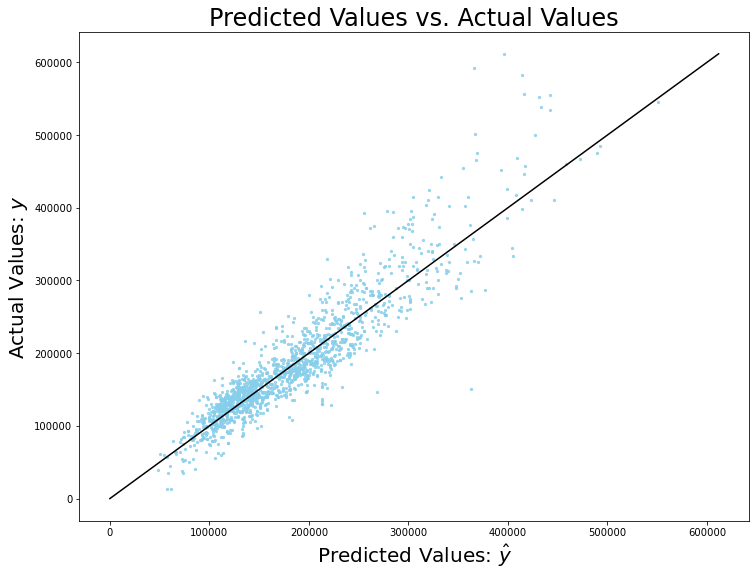

In [17]:
# Code from 3.01-lesson-linear_regression 
# Plot the model
plt.figure(figsize=(12,9))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(np.exp(y_pred), np.exp(y_train), s=5, color='skyblue', alpha = 0.8)

# Plot a line.
plt.plot([0, np.exp(np.max(y))],
         [0, np.exp(np.max(y))],
         color = 'black')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

I see my predictions spread out more after around $300,000. My model is not good at predicting higher priced homes.

### 6. Run model on Kaggle test data

Set up X and y variables on Kaggle test dataset

In [18]:
# get the log of general living area
kaggle_test["gr_liv_area_log"] = np.log(kaggle_test["gr_liv_area"])

In [19]:
# set my X variable
X_kaggle = kaggle_test[features]

In [20]:
# generate predictions
y_preds = np.exp(lr.predict(X_kaggle))

In [21]:
# create a pandas dataframe for my predictions
submission = pd.DataFrame(y_preds, index=kaggle_test.index, columns=['SalePrice'])

In [22]:
# sort by index
submission.sort_index(inplace=True)

### Write out submission

In [23]:
# write to csv
submission.to_csv("../datasets/submission_mlr_8.csv")

# Try polyfeatures

### 1. Set up polynomial variables

In [24]:
# Instantiate PolynomialFeatures
poly = PolynomialFeatures(include_bias = False)

In [25]:
# Create X_poly
X_poly = poly.fit_transform(X)
#X_kaggle_poly = poly.fit_transform(X_kaggle)
X_poly

array([[8., 6., 2., ..., 0., 0., 0.],
       [5., 7., 2., ..., 1., 0., 0.],
       [7., 5., 1., ..., 0., 0., 0.],
       ...,
       [6., 6., 1., ..., 1., 0., 0.],
       [5., 4., 1., ..., 4., 0., 0.],
       [5., 7., 2., ..., 1., 0., 0.]])

In [26]:
# View X_poly in a DataFrame
pd.DataFrame(X_poly, columns = poly.get_feature_names(features))

,overall_cond,overall_qual,full_bath,bedroom_abvgr,has_remodel,year_built,gr_liv_area,central_air,fireplaces,has_pool,overall_cond^2,overall_cond overall_qual,overall_cond full_bath,overall_cond bedroom_abvgr,overall_cond has_remodel,overall_cond year_built,overall_cond gr_liv_area,overall_cond central_air,overall_cond fireplaces,overall_cond has_pool,overall_qual^2,overall_qual full_bath,overall_qual bedroom_abvgr,overall_qual has_remodel,overall_qual year_built,overall_qual gr_liv_area,overall_qual central_air,overall_qual fireplaces,overall_qual has_pool,full_bath^2,full_bath bedroom_abvgr,full_bath has_remodel,full_bath year_built,full_bath gr_liv_area,full_bath central_air,full_bath fireplaces,full_bath has_pool,bedroom_abvgr^2,bedroom_abvgr has_remodel,bedroom_abvgr year_built,bedroom_abvgr gr_liv_area,bedroom_abvgr central_air,bedroom_abvgr fireplaces,bedroom_abvgr has_pool,has_remodel^2,has_remodel year_built,has_remodel gr_liv_area,has_remodel central_air,has_remodel fireplaces,has_remodel has_pool,year_built^2,year_built gr_liv_area,year_built central_air,year_built fireplaces,year_built has_pool,gr_liv_area^2,gr_liv_area central_air,gr_liv_area fireplaces,gr_liv_area has_pool,central_air^2,central_air fireplaces,central_air has_pool,fireplaces^2,fireplaces has_pool,has_pool^2
0,8.0,6.0,2.0,3.0,1.0,1976.0,1479.0,1.0,0.0,0.0,64.0,48.0,16.0,24.0,8.0,15808.0,11832.0,8.0,0.0,0.0,36.0,12.0,18.0,6.0,11856.0,8874.0,6.0,0.0,0.0,4.0,6.0,2.0,3952.0,2958.0,2.0,0.0,0.0,9.0,3.0,5928.0,4437.0,3.0,0.0,0.0,1.0,1976.0,1479.0,1.0,0.0,0.0,3904576.0,2922504.0,1976.0,0.0,0.0,2187441.0,1479.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5.0,7.0,2.0,4.0,1.0,1996.0,2122.0,1.0,1.0,0.0,25.0,35.0,10.0,20.0,5.0,9980.0,10610.0,5.0,5.0,0.0,49.0,14.0,28.0,7.0,13972.0,14854.0,7.0,7.0,0.0,4.0,8.0,2.0,3992.0,4244.0,2.0,2.0,0.0,16.0,4.0,7984.0,8488.0,4.0,4.0,0.0,1.0,1996.0,2122.0,1.0,1.0,0.0,3984016.0,4235512.0,1996.0,1996.0,0.0,4502884.0,2122.0,2122.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,7.0,5.0,1.0,3.0,1.0,1953.0,1057.0,1.0,0.0,0.0,49.0,35.0,7.0,21.0,7.0,13671.0,7399.0,7.0,0.0,0.0,25.0,5.0,15.0,5.0,9765.0,5285.0,5.0,0.0,0.0,1.0,3.0,1.0,1953.0,1057.0,1.0,0.0,0.0,9.0,3.0,5859.0,3171.0,3.0,0.0,0.0,1.0,1953.0,1057.0,1.0,0.0,0.0,3814209.0,2064321.0,1953.0,0.0,0.0,1117249.0,1057.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5.0,5.0,2.0,3.0,1.0,2006.0,1444.0,1.0,0.0,0.0,25.0,25.0,10.0,15.0,5.0,10030.0,7220.0,5.0,0.0,0.0,25.0,10.0,15.0,5.0,10030.0,7220.0,5.0,0.0,0.0,4.0,6.0,2.0,4012.0,2888.0,2.0,0.0,0.0,9.0,3.0,6018.0,4332.0,3.0,0.0,0.0,1.0,2006.0,1444.0,1.0,0.0,0.0,4024036.0,2896664.0,2006.0,0.0,0.0,2085136.0,1444.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,8.0,6.0,2.0,3.0,1.0,1900.0,1445.0,1.0,0.0,0.0,64.0,48.0,16.0,24.0,8.0,15200.0,11560.0,8.0,0.0,0.0,36.0,12.0,18.0,6.0,11400.0,8670.0,6.0,0.0,0.0,4.0,6.0,2.0,3800.0,2890.0,2.0,0.0,0.0,9.0,3.0,5700.0,4335.0,3.0,0.0,0.0,1.0,1900.0,1445.0,1.0,0.0,0.0,3610000.0,2745500.0,1900.0,0.0,0.0,2088025.0,1445.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,5.0,8.0,2.0,3.0,0.0,2007.0,1728.0,1.0,1.0,0.0,25.0,40.0,10.0,15.0,0.0,10035.0,8640.0,5.0,5.0,0.0,64.0,16.0,24.0,0.0,16056.0,13824.0,8.0,8.0,0.0,4.0,6.0,0.0,4014.0,3456.0,2.0,2.0,0.0,9.0,0.0,6021.0,5184.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4028049.0,3468096.0,2007.0,2007.0,0.0,2985984.0,1728.0,1728.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2045,5.0,4.0,1.0,1.0,1.0,1940.0,861.0,1.0,0.0,0.0,25.0,20.0,5.0,5.0,5.0,9700.0,4305.0,5.0,0.0,0.0,16.0,4.0,4.0,4.0,7760.0,3444.0,4.0,0.0,0.0,1.0,1.0,1.0,1940.0,861.0,1.0,0.0,0.0,1.0,1.0,1940.0,861.0,1.0,0.0,0.0,1.0,1940.0,861.0,1.0,0.0,0.0,3763600.0,1670340.0,1940.0,0.0,0.0,741321.0,861.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2046,6.0,6.0,1.0,3.0,1.0,1928.0,1913.0,1.0,1.0,0.0,36.0,36.0,6.0,18.0,6.0,11568.0,11478.0,6.0,6.0,0.0,36.0,6.

### 2. Split data into test and train

In [27]:
# split data into train and test
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, random_state= 123)

### 3. Fit a linear regression model

In [28]:
lr = LinearRegression()
lr.fit(X_poly_train, y_poly_train)

LinearRegression()

### 4. Evaluate model

In [29]:
# cross validation score
cross_val_score(lr, X_poly_train, y_poly_train, cv = 5).mean()

0.8397865872592509

In [30]:
# Train score
lr.score(X_poly_train, y_poly_train)

0.8664797487011551

In [31]:
# Test score
lr.score(X_poly_test, y_poly_test)

0.849784281727992

Model is overfit to my training data when using poly features.

# Run a statsmodel

In [32]:
# create a constant for X in SM
X_train_sm = sm.add_constant(X_train) 


In [33]:
model_sm = sm.OLS(y_train, X_train).fit() # instantiate and fit model

In [34]:
# generate predictions
y_pred_sm = model_sm.predict(X_train)

In [35]:
# model summary
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          saleprice_log   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          8.256e+05
Date:                Mon, 03 May 2021   Prob (F-statistic):                        0.00
Time:                        16:20:01   Log-Likelihood:                          600.39
No. Observations:                1536   AIC:                                     -1181.
Df Residuals:                    1526   BIC:                                     -1127.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
overall_cond      0.0621      0.004     15.021      0.000       0.054       0.070
overall_qual      0.0960      0.004     22.743      0.000       0.088       0.104
full_bath        -0.0271      0.011     -2.538      0.011      -0.048      -0.006
bedroom_abvgr    -0.0234      0.006     -3.609      0.000      -0.036      -0.011
has_remodel       0.0300      0.009      3.290      0.001       0.012       0.048
year_built        0.0053   1.74e-05    305.614      0.000       0.005       0.005
gr_liv_area       0.0004   1.55e-05     22.911      0.000       0.000       0.000
central_air       0.1107      0.018      6.089      0.000       0.075       0.146
fireplaces        0.0720      0.008      9.276      0.000       0.057       0.087
has_pool          0.0444      0.083      0.534      0.593      -0.119       0.207
==============================================================================
Omnibus:                      514.402   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6014.419
Skew:                          -1.218   Prob(JB):                         0.00
Kurtosis:                      12.383   Cond. No.                     4.95e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.95e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Try this model on kaggle test data

In [36]:
# set up my X variable
X_kaggle_sm = sm.add_constant(X_kaggle) 

# generate predictions
y_preds = np.exp(model_sm.predict(X_kaggle_sm))

# create submissions dataframe
submission = pd.DataFrame(y_preds, index=kaggle_test.index, columns=['SalePrice'])
submission.sort_index(inplace=True)

ValueError: shapes (878,11) and (10,) not aligned: 11 (dim 1) != 10 (dim 0)

In [ ]:
# write to csv
submission.to_csv("../datasets/submission_mlr_9.csv")